In [1]:
from src.data.diabetes_datasets.data_loader import get_loader
from datetime import datetime

loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)

2025-11-19T01:47:51 - ============================================================
2025-11-19T01:47:51 - Beginning data loading process with the following parmeters:
2025-11-19T01:47:51 - 	Dataset: kaggle_brisT1D - train
2025-11-19T01:47:51 - 	Columns: None
2025-11-19T01:47:51 - 	Generic patient start date: 2024-01-01 00:00:00
2025-11-19T01:47:51 - 	Number of validation days: 20
2025-11-19T01:47:51 - 	In parallel with up to 3 workers.

2025-11-19T01:47:52 - Loaded full processed data from cache for 9 patients
2025-11-19T01:47:52 - Loaded existing train/validation split from cache for 9 patients


## Configuration

In [2]:
from src.data.models import ColumnNames

INTERVAL_MINS = 5
# https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-chronos.html
# Prediction length: 8 hours ahead
PREDICTION_HOURS = 8

INTERVAL_MINS = 5
TRAIN_HOURS = 40
PREDICTION_HOURS = 8

prediction_length = int((PREDICTION_HOURS * 60) / INTERVAL_MINS)
context_length = int(TRAIN_HOURS * 60 / INTERVAL_MINS)

EXOG_COLS = [
    ColumnNames.DOSE_UNITS.value,
    ColumnNames.FOOD_G.value,
    ColumnNames.COB.value,
    ColumnNames.CARB_AVAILABILITY.value,
    ColumnNames.IOB.value,
    ColumnNames.INSULIN_AVAILABILITY.value,
]

### Prepare data for AutoGluon

run `pip install autogluon`

In [3]:
import pandas as pd
from typing import cast
from src.utils.time_series_helper import get_interval_minutes
from autogluon.timeseries import TimeSeriesDataFrame
from src.data.models import ColumnNames


def prepare_data(
    df: dict[str, pd.DataFrame], exog_cols: list[str]
) -> TimeSeriesDataFrame:
    """
    Prepare data for AutoGluon
    Args:
        df: dict[str, pd.DataFrame]
            Dictionary of patient IDs and their data
        exog_cols: list[str]
            List of exogenous variables
    Returns:
        TimeSeriesDataFrame
    """
    train_data_list = []
    for patient_id, patient_df in df.items():
        target_col = ColumnNames.BG.value
        if get_interval_minutes(patient_df) != INTERVAL_MINS:
            continue

        # Ensure datetime index
        if not isinstance(patient_df.index, pd.DatetimeIndex):
            if "datetime" in patient_df.columns:
                patient_df = patient_df.set_index("datetime")
            else:
                raise ValueError(
                    f"Patient {patient_id} data doesn't have datetime index or column"
                )

        if len(patient_df) > 0:
            # Prepare data (exogenous variables + target)
            train_data = patient_df[exog_cols + [target_col]].copy()
            # TimeSeriesDataFrame expects a MultiIndex with 'item_id' and 'timestamp'
            train_data.index = pd.MultiIndex.from_product(
                [[patient_id], train_data.index], names=["item_id", "timestamp"]
            )
            train_data_list.append(train_data)

    # Combine all patients into DataFrames
    glucose_train_df = pd.concat(train_data_list)
    print("  - Original data shape:", glucose_train_df.shape)

    train_df = TimeSeriesDataFrame(glucose_train_df)
    return train_df

### Output directory

In [4]:
from src.utils.os_helper import get_project_root
from autogluon.timeseries import TimeSeriesPredictor

root = get_project_root()
dataset_name = loader.dataset_name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
models_dir = root / "models" / "chronos"
output_dir = models_dir / dataset_name / f"{INTERVAL_MINS}min" / timestamp

### Zero-shot settings

In [ ]:
# Prepare data for AutoGluon - split into train and validation periods
if (
    loader.train_data is None
    or loader.validation_data is None
    or loader.processed_data is None
):
    raise ValueError("No training data found")

# Use the entire data for oneshot is fine
processed_data: dict[str, pd.DataFrame] = cast(
    dict[str, pd.DataFrame], loader.processed_data
)
data = prepare_data(processed_data, EXOG_COLS)
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=ColumnNames.BG.value,
    eval_metric="RMSE",
    path=output_dir,
)

predictor.fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "amazon/chronos-bolt-small",
            "context_length": context_length,
            # "covariate_regressor": "CAT" -- This is for known_covariates only
        },
    },
)

## Double check the past_covariates in the log has all the exogenous variables (this is inferred from the dataset)
## All columns that is not the target column or known_covariates (exogenous variables during prediction) are past_covariates

Training with 40 hours to predict next 8 hours
Prediction length: 96 time steps (8 hours)
Context length: 480 time steps (40 hours)


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\models\chronos\kaggle_brisT1D\5min\20251117_181821'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          1
Memory Avail:       16.56 GB / 31.15 GB (53.2%)
Disk Space Avail:   455.46 GB / 1862.20 GB (24.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'Chronos': {'context_length': 480,
                                 'model_path': 'amazon/chronos-bolt-small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 96,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'bg_mM',
 'verbosity': 2}

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-2.0792       = Validation score (-RMSE)
	10.14   s     = Training runtime
	3.07    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['Chronos[amazon__chronos-bolt-small]']
Total runtime: 13.25 s
Best model: Chronos[amazon__chronos-bolt-small]
Best model score: -2.0792


### Plot

Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]


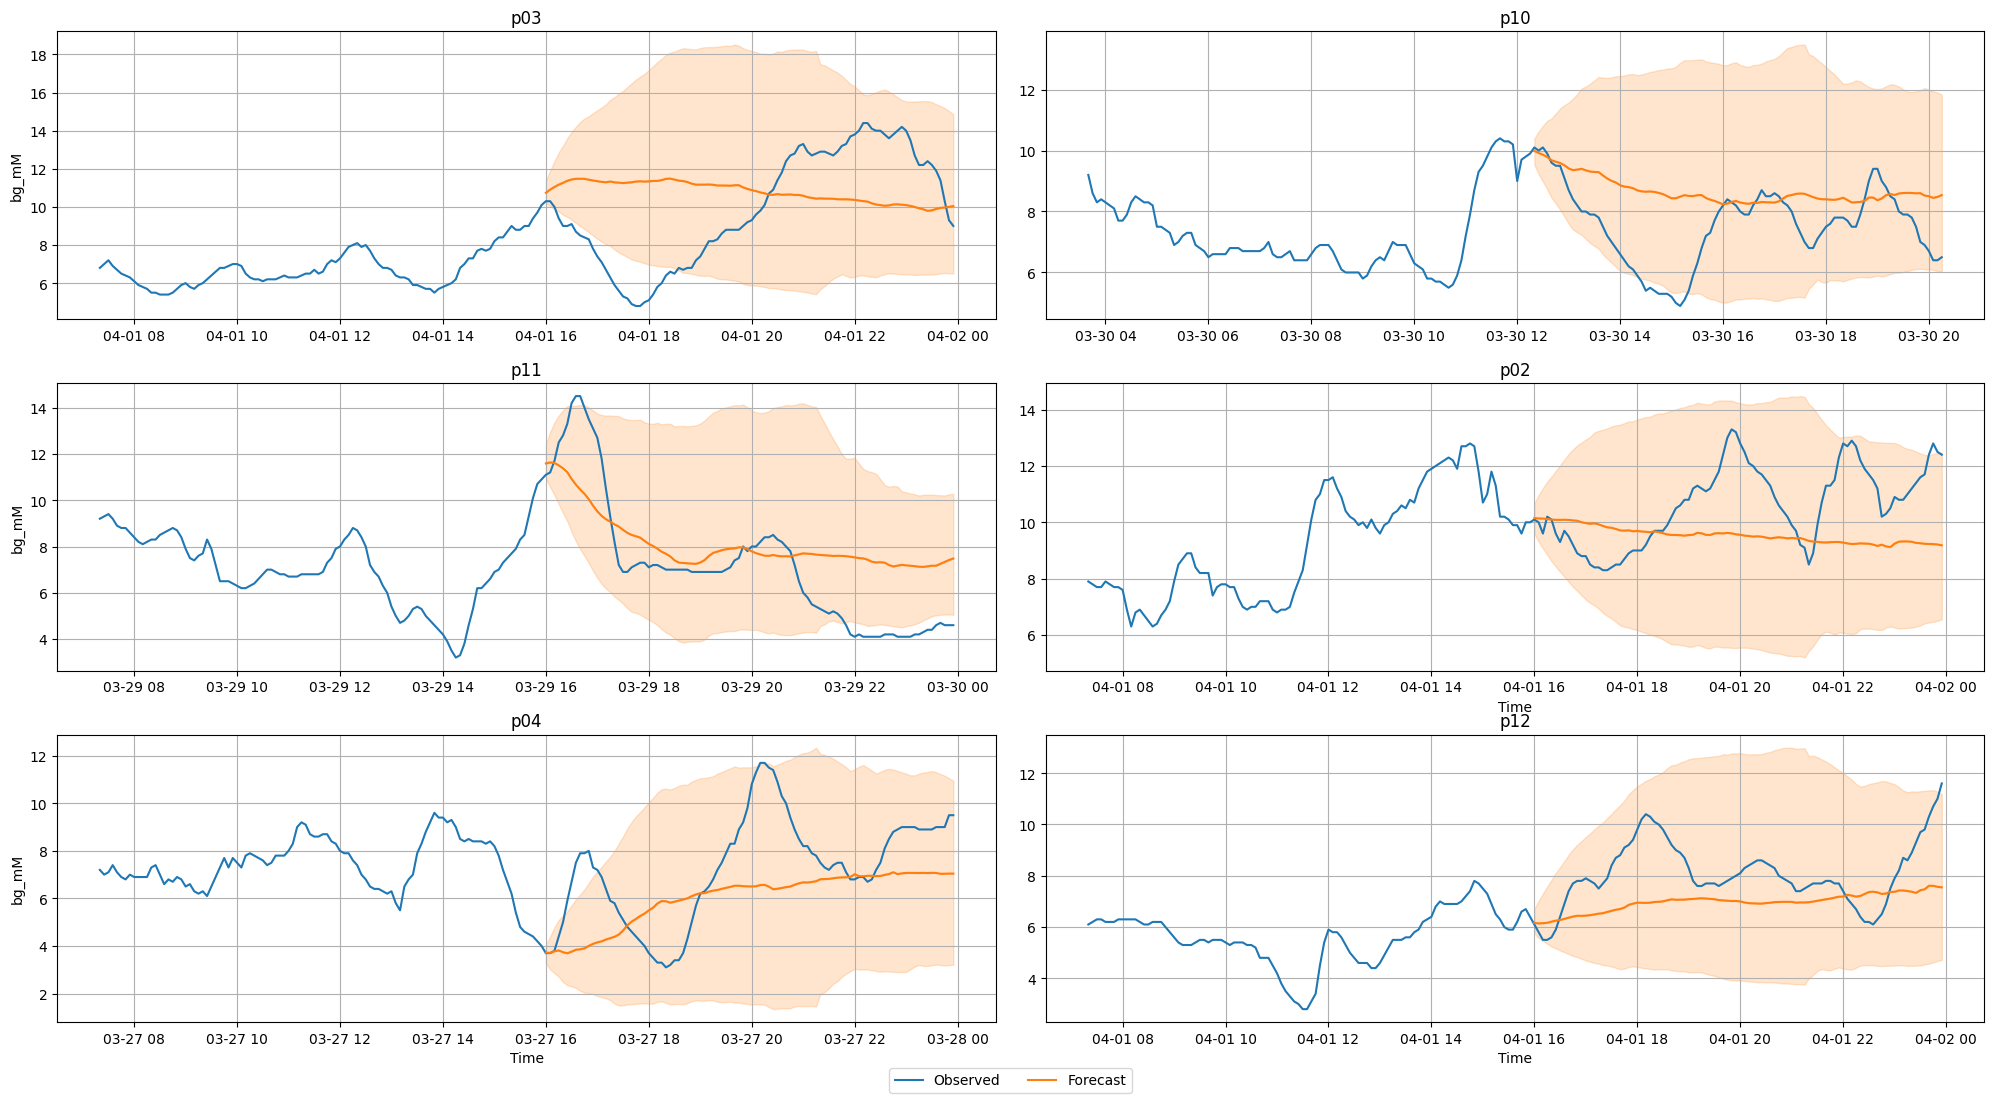

In [ ]:
%matplotlib inline
predictions = predictor.predict(train_data)

predictor.plot(
    data=data,  # This is the entire data
    predictions=predictions,
    max_history_length=200,
)

### Eval
Only evaluate for a prediction_length worth of data

In [ ]:
predictor.evaluate(test_data)

# All metric are reported in higher is better
# RMSE is multiplied by -1 so higher is better

Model not specified in predict, will default to the model with the best validation score: Chronos[amazon__chronos-bolt-small]


{'RMSE': -2.2589322344079226}

## Fine-tune Settings
Reference: https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-chronos.html#fine-tuning

All Chronos fine-tuning options: https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-model-zoo.html#autogluon.timeseries.models.ChronosModel

Transformer Args: https://huggingface.co/docs/transformers/en/main_classes/trainer

## Training Flow: AutoGluon + Chronos Fine-Tuning

### Phase 1: AutoGluon Level (Expanding Window Split)
| Component | Data Range |
|-----------|------------|
| train_fold | `[1, ..., N-96]` |
| val_fold | `[N-95, ..., N]` |

### Phase 2: Chronos Level (Random Sliding Windows - Infinite Dataset)

**Note:** ChronosFineTuningDataset is infinite (cycles forever, generates random windows indefinitely)

#### Training Configuration
- `fine_tune_steps = 10,000,000` → `max_steps = 10,000,000`
- `batch_size = 64`

#### Training Process
| Step | Action |
|------|--------|
| Step 1 | Batch 1: 64 random windows → train |
| Step 2 | Batch 2: 64 random windows → train |
| Step 3 | Batch 3: 64 random windows → train |
| ... | ... (continues generating random windows) |
| Step 10,000,000 | Final batch: 64 random windows → train |
| After Step 10,000,000 | Training stops (max_steps reached) |

**Total:** 10,000,000 steps = 10,000,000 batches = 640,000,000 windows (10M × 64)

#### Validation
- Validation occurs based on `eval_strategy` setting (e.g., every N steps or at end)
- Uses `val_fold` (last 96 time steps of each time series)

#### Notes
- Dataset is infinite: keeps generating new random windows forever (an finite tape)
- Training stops at `max_steps` (10M steps), not after 3 epochs
- Random windows are sampled on-the-fly during training by picking a random position on the tape and extract a window of size `context_length` + `prediction_length`
- Each batch contains 64 random windows sampled from `train_fold`


Note on infinite dataset:

https://github.com/Lightning-AI/pytorch-lightning/issues/2150

In [7]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"{models_dir}/fine_tune/{timestamp}"

# Resume where it left off???? Need to figure this out. It doesn't work
# output_dir = "models/chronos/fine_tune/20251119_012235"

train_data = prepare_data(loader.train_data, EXOG_COLS)
# This is the holdout set we will be using for model evaluation
test_data = prepare_data(loader.validation_data, EXOG_COLS)


predictor_ft = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=ColumnNames.BG.value,
    eval_metric="RMSE",
    path=output_dir,
)

predictor_ft.fit(
    train_data=train_data,
    num_val_windows=1,  # Only validate with one window (last prediction_length worth of data)
    hyperparameters={
        "Chronos": [
            # It looks like that the params can be a search space too for grid search
            {
                "model_path": "bolt_small",
                "fine_tune": True,
                "ag_args": {"name_suffix": "FineTuned"},
                "fine_tune_lr": 1e-4,
                "fine_tune_steps": 10000,
                "device": None,
                "context_length": context_length,
                # "eval_during_fine_tune": True,  # Evaluate the model during fine-tuning
                "fine_tune_trainer_kwargs": {
                    "output_dir": output_dir,
                    "save_strategy": "steps",
                    "save_steps": 1000,
                    "eval_strategy": "steps",
                    "eval_steps": 1000,
                    # "num_train_epochs": 3, # Doesn't make sense in the context of infinite dataset
                    "save_total_limit": 5,
                    "per_device_train_batch_size": 64,
                    "per_device_eval_batch_size": 64,
                },
                "keep_transformers_logs": True,
            },
            # Can fit multiple models at once
        ]
    },
    time_limit=1 * 60 * 60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\models\chronos\fine_tune\20251119_015547'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          1
Memory Avail:       11.75 GB / 31.15 GB (37.7%)
Disk Space Avail:   435.42 GB / 1862.20 GB (23.4%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': RMSE,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTuned'},
                                  'context_length': 480,
                                  'device': None,
                                  'fine_tune': True,
                                  'fine_tune_lr': 0.0001,
                                  'fine_tune_steps': 10000,
                                  'fine_tune_trainer_kwarg

  - Original data shape: (119816, 7)
  - Original data shape: (34566, 7)


	Saving fine-tuned model to c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\models\chronos\fine_tune\20251119_015547\models\ChronosFineTuned[bolt_small]\W0\fine-tuned-ckpt
	-2.7093       = Validation score (-RMSE)
	537.36  s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosFineTuned[bolt_small]']
Total runtime: 537.46 s
Best model: ChronosFineTuned[bolt_small]
Best model score: -2.7093


### Evaludation on holdout set: WIP

In [8]:
predictor_ft.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


{'RMSE': -2.3909084380197267}

### Plot: WIP